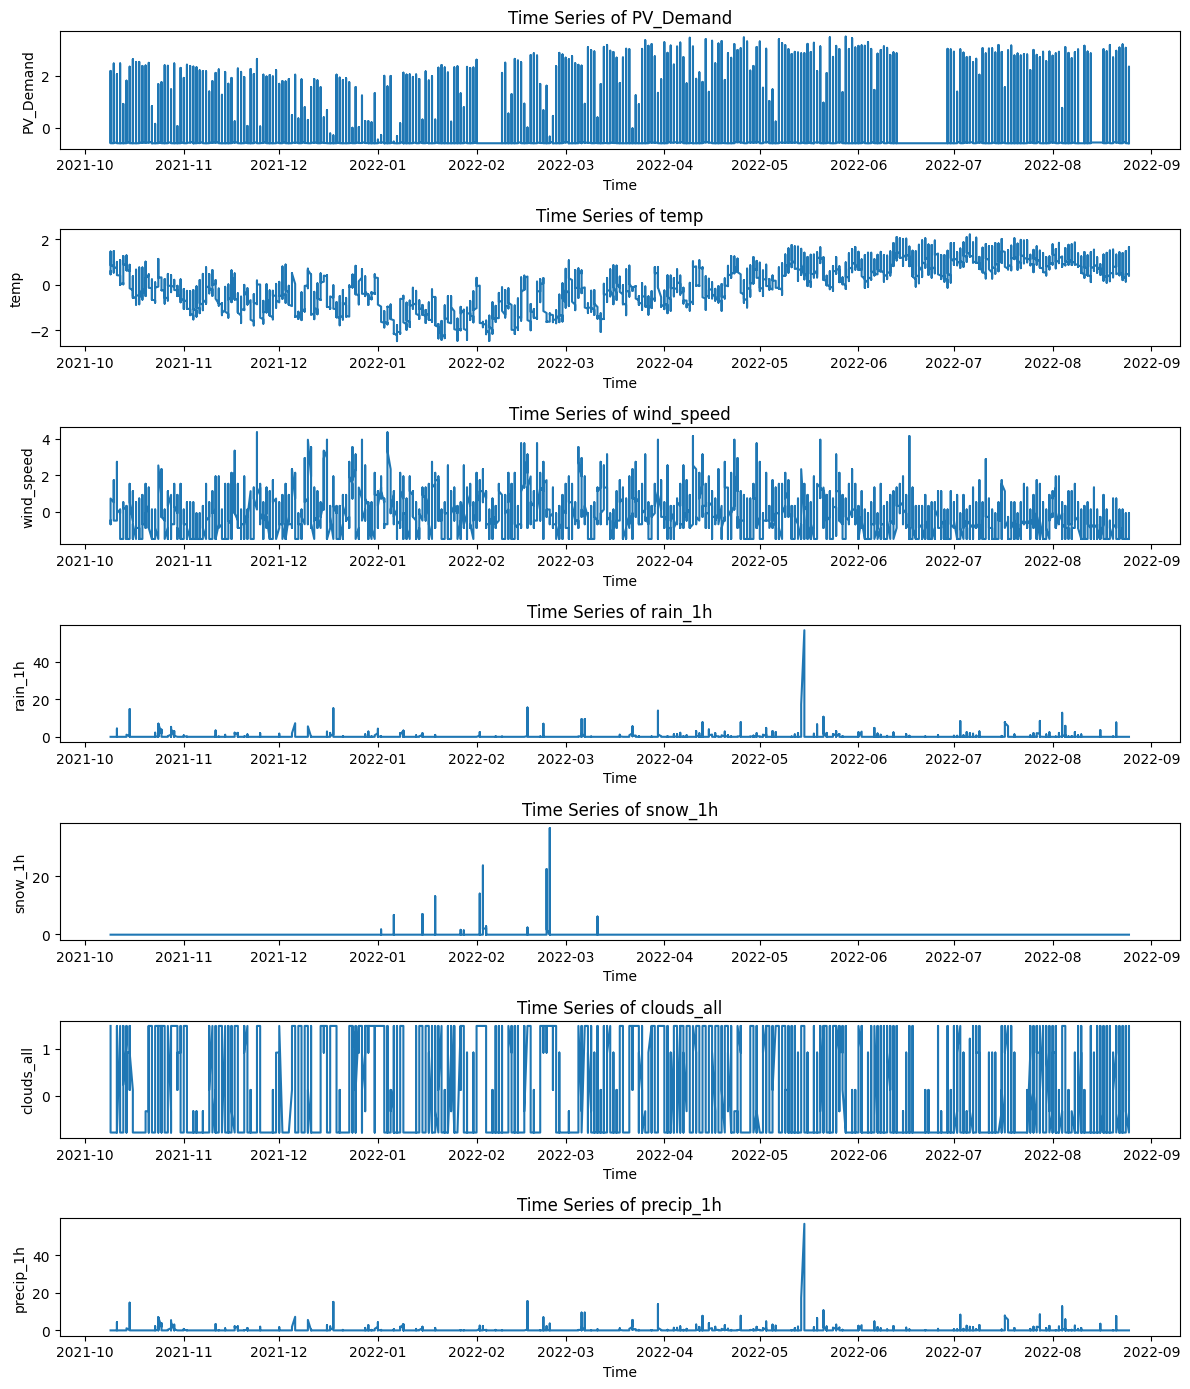

In [17]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout, Multiply, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)
tf.config.experimental.enable_op_determinism()

if tf.config.list_physical_devices('GPU'):
    try:
        for device in tf.config.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(device, True)
    except:
        print("Failed to set memory growth on GPU for determinism.")
    K.set_floatx('float32')
else:
    print("No GPU found; running on CPU.")


df = pd.read_csv('/content/Sopan-Finder.csv')


if 'Solar Panel State' in df.columns:
    df = df.drop(columns=['Solar Panel State'])

df_modified = df.copy()
df['DateTime'] = pd.to_datetime(df['Date'].astype(str))
df.set_index('DateTime', inplace=True)

features_to_plot = df.drop(columns=['Anomaly', 'Date', 'Month', 'Day', 'Hour', 'Minute'])
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_to_plot),
                               columns=features_to_plot.columns,
                               index=df.index)
fe1 = 1.1
fe2 = 2.8
fe3 = 1.5
nl = 0.1

# Plot time series for each feature
plt.figure(figsize=(12, 14))
for i, feature in enumerate(features_scaled.columns, 1):
    plt.subplot(len(features_scaled.columns), 1, i)
    plt.plot(features_scaled.index, features_scaled[feature], label=feature)
    plt.title(f'Time Series of {feature}')
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.savefig(f'{feature}_time_series.png')

plt.show()


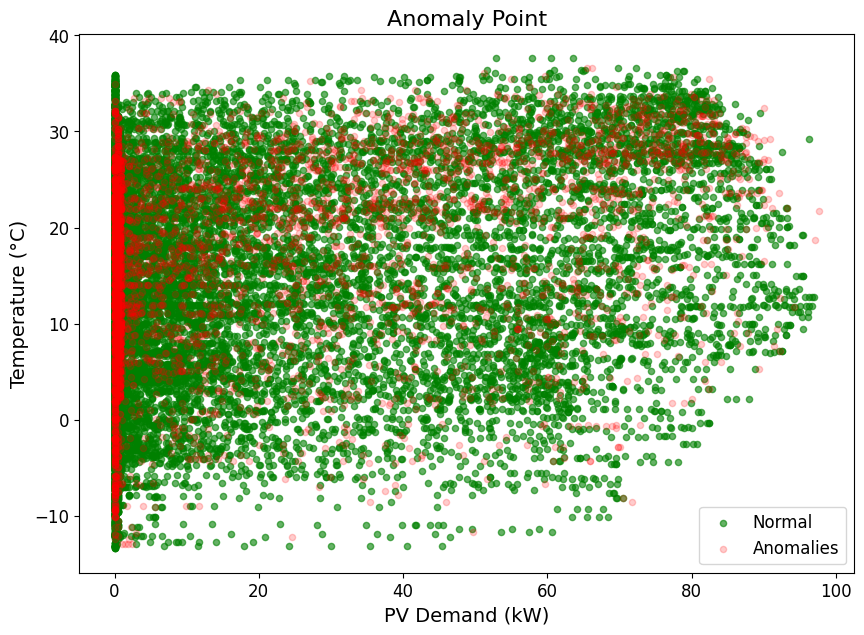

In [18]:
df['temp_C'] = df['temp'] - 273.15
normal_data = df[df['Anomaly'] == 0]
anomalies_data = df[df['Anomaly'] == 1]
df_modified['clouds_all'] = df_modified['clouds_all'].astype(float)
df_modified['Hour'] = df_modified['Hour'].astype(float)
df_modified.loc[df_modified['Anomaly'] == 1, 'PV_Demand'] *= fe2 * (1 + nl * np.random.randn(sum(df_modified['Anomaly'] == 1)))
df_modified.loc[df_modified['Anomaly'] == 1, 'temp'] *= fe1 * (1 + nl * np.random.randn(sum(df_modified['Anomaly'] == 1)))
df_modified.loc[df_modified['Anomaly'] == 1, 'wind_speed'] *= fe3 * (1 + nl * np.random.randn(sum(df_modified['Anomaly'] == 1)))
df_modified.loc[df_modified['Anomaly'] == 1, 'clouds_all'] *= fe1 * (1 + nl * np.random.randn(sum(df_modified['Anomaly'] == 1)))
df_modified.loc[df_modified['Anomaly'] == 1, 'Hour'] *= fe3 * (1 + nl * np.random.randn(sum(df_modified['Anomaly'] == 1)))
plt.figure(figsize=(10, 7))
plt.scatter(normal_data['PV_Demand'], normal_data['temp_C'],
            color='green', alpha=0.6, label='Normal', s=20)
plt.scatter(anomalies_data['PV_Demand'], anomalies_data['temp_C'],
            color='red', alpha=0.2, label='Anomalies', s=20)
plt.xlabel('PV Demand (kW)', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.title('Anomaly Point', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)


# Step 7: Show the plot
plt.show()

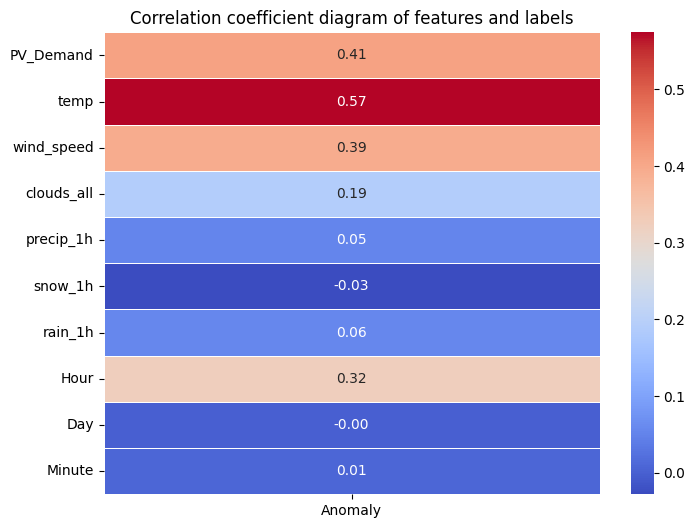

In [19]:
original_features = ['PV_Demand', 'temp', 'wind_speed', 'clouds_all', 'precip_1h', 'snow_1h', 'rain_1h', 'Hour', 'Day', 'Minute']
correlation_matrix = df_modified[original_features + ['Anomaly']].corr()
correlation_with_anomaly = correlation_matrix.loc[original_features, 'Anomaly']
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_with_anomaly.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation coefficient diagram of features and labels')
# Display the plot
plt.show()

In [20]:
features = ['temp', 'wind_speed', 'clouds_all', 'Hour', 'PV_Demand']
X = df[features].values
labels = df['Anomaly'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
# Create a sliding window function
def create_sliding_windows(data, labels, window_size):
    X, y, start_indices = [], [], []
    for i in range(len(data) - window_size + 1):
        X.append(data[i:i + window_size])
        y.append(labels[i + window_size - 1])
        start_indices.append(i)
    return np.array(X), np.array(y), np.array(start_indices)
# Define sliding window size
window_size = 10
X_windows, y_windows, start_indices = create_sliding_windows(X_scaled, labels, window_size)

train_indices, test_indices = train_test_split(
    start_indices, test_size=0.2, random_state=42, shuffle=True
)

X_train = X_windows[train_indices]
X_test = X_windows[test_indices]
y_train = y_windows[train_indices]
y_test = y_windows[test_indices]


In [22]:
input_layer = Input(shape=(window_size, X_train.shape[2]))
encoded = LSTM(128, activation='relu', return_sequences=True)(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = LSTM(64, activation='relu', return_sequences=False)(encoded)
# Memory
memory_slots = 200
memory_vectors = Dense(memory_slots, activation='relu')(encoded)
memory_weights = Softmax()(memory_vectors)
memory_output = Multiply()([memory_weights, memory_vectors])
decoded = RepeatVector(window_size)(memory_output)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = Dropout(0.2)(decoded)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
output_layer = TimeDistributed(Dense(X_train.shape[2]))(decoded)
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

In [23]:
def build_discriminator(input_shape):
    discriminator_input = Input(shape=input_shape)
    x = LSTM(64, activation='relu', return_sequences=True)(discriminator_input)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu', return_sequences=False)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(discriminator_input, output)

discriminator = build_discriminator((window_size, X_train.shape[2]))
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
def build_predictor(input_shape):
    predictor_input = Input(shape=input_shape)
    x = LSTM(128, activation='relu', return_sequences=True)(predictor_input)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, activation='relu', return_sequences=False)(x)
    prediction = Dense(input_shape[-1])(x)
    return Model(predictor_input, prediction)

predictor = build_predictor((window_size, X_train.shape[2]))
predictor.compile(optimizer='adam', loss='mse')


In [25]:
batch_size = 64
epochs = 50
early_stopping_patience = 10  # Number of early stop tolerances for discriminator
best_disc_val_loss = float('inf')  # Initialization of optimal verification loss
wait = 0

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}")
    autoencoder.fit(
        X_train, X_train,
        epochs=1, batch_size=batch_size, validation_split=0.2,
        shuffle=True, callbacks=[early_stopping], verbose=0
    )
    X_fake = autoencoder.predict(X_train)
    X_combined = np.concatenate([X_train, X_fake], axis=0)
    y_combined = np.concatenate([np.ones(len(X_train)), np.zeros(len(X_fake))], axis=0)
    history = discriminator.fit(
        X_combined, y_combined,
        epochs=1, batch_size=batch_size, validation_split=0.2,
        shuffle=True, verbose=0
    )
    disc_val_loss = history.history['val_loss'][0]
    if disc_val_loss < best_disc_val_loss:
        best_disc_val_loss = disc_val_loss
        wait = 0
    else:
        wait += 1
    if wait >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break
    disc_loss, disc_accuracy = discriminator.evaluate(X_combined, y_combined, verbose=0)
    print(f"Discriminator - Loss: {disc_loss:.4f}, Accuracy: {disc_accuracy:.4f}")

print("Training complete.")

Epoch 1
771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
Discriminator - Loss: 0.1535, Accuracy: 0.9465
Epoch 2
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.4186, Accuracy: 0.8142
Epoch 3
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.3153, Accuracy: 0.8497
Epoch 4
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.3224, Accuracy: 0.8616
Epoch 5
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.2932, Accuracy: 0.8695
Epoch 6
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.2001, Accuracy: 0.9152
Epoch 7
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.3761, Accuracy: 0.8191
Epoch 8
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.2424, Accuracy: 0.8957
Epoch 9
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.2829, Accuracy: 0.8709
Epoch 10
771/771 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Discriminator - Loss: 0.1177, Accuracy: 0.9645
Epoch 11
771/771 ━━━━━━━━━━━━━━━━━━━━ 2

In [26]:
predictor = build_predictor((window_size, X_train.shape[2]))
predictor.compile(optimizer='adam', loss='mse')

predictor.fit(
    X_train, X_train[:, -1, :],
    epochs=50, batch_size=batch_size, validation_split=0.2,
    shuffle=True, callbacks=[early_stopping], verbose=1
)

Epoch 1/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - loss: 0.3597 - val_loss: 0.0459
Epoch 2/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0614 - val_loss: 0.0212
Epoch 3/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0370 - val_loss: 0.0143
Epoch 4/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0285 - val_loss: 0.0083
Epoch 5/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0226 - val_loss: 0.0099
Epoch 6/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0200 - val_loss: 0.0059
Epoch 7/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - val_loss: 0.0104
Epoch 8/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - val_loss: 0.0051
Epoch 9/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0146 - val_loss: 0.0063
Epoch 10/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0132 - val_loss: 0.0062
Epoch 11/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0127 - val_loss: 0.0074
Epoch 12/50
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/st

In [27]:
X_test_pred = autoencoder.predict(X_test)
X_test_forward_pred = predictor.predict(X_test)

test_reconstruction_error = np.mean(np.power(X_test - X_test_pred, 2), axis=(1, 2))
test_prediction_error = np.mean(np.power(X_test[:, -1, :] - X_test_forward_pred, 2), axis=1)

def dynamic_threshold(errors, window_size=50, percentile=85):
    thresholds = [np.percentile(errors[max(0, i - window_size):i + 1], percentile) for i in range(len(errors))]
    return np.array(thresholds)

combined_test_error = 0.7 * test_reconstruction_error + 0.3 * test_prediction_error
combined_test_threshold = dynamic_threshold(combined_test_error, 50, 85)

y_test_pred = (combined_test_error > combined_test_threshold).astype(int)

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


ROC curve saved as 'roc_curve.png'


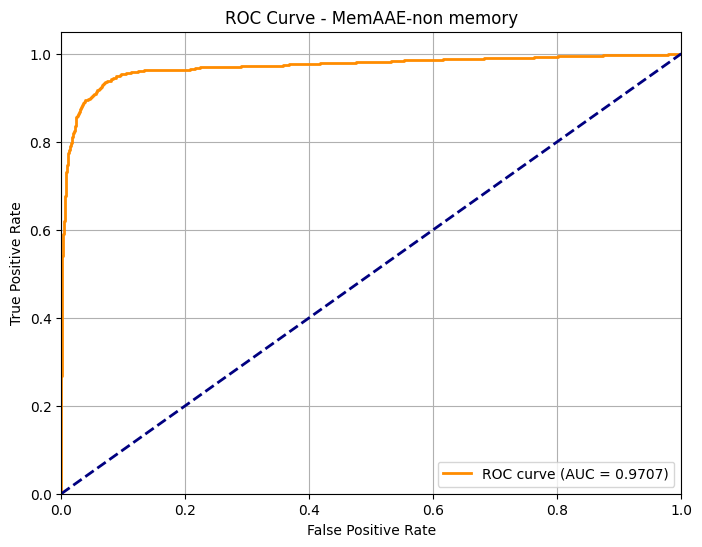

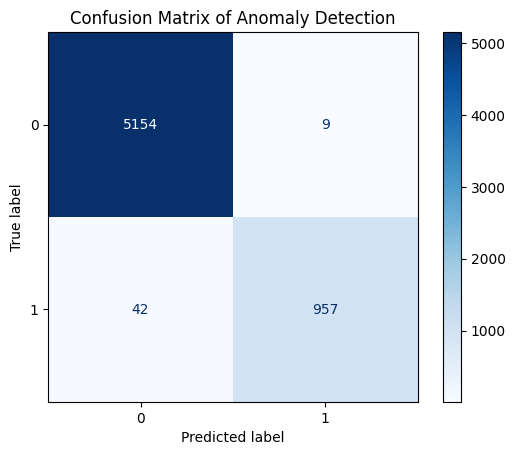

      Metric     Value
0   Accuracy  0.991723
1   F1 Score  0.974046
2     Recall  0.957958
3  Precision  0.990683


In [28]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, combined_test_error)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - MemAAE-non memory')
plt.legend(loc='lower right')
plt.grid(True)

# Save ROC curve as a PNG file
plt.savefig('roc_curve.png', bbox_inches='tight')
print("ROC curve saved as 'roc_curve.png'")

# Show ROC plot
plt.show()

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Anomaly Detection")

# Save the confusion matrix plot
plt.savefig('confusion_matrix_anomaly_detection.png')
plt.show()

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

# Organize results into a DataFrame for a clean table display
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Recall', 'Precision'],
    'Value': [accuracy, f1, recall, precision]
})

# Display the table of metrics
print(metrics_df)


Plot saved at: /content/last_300_samples_comparison.png


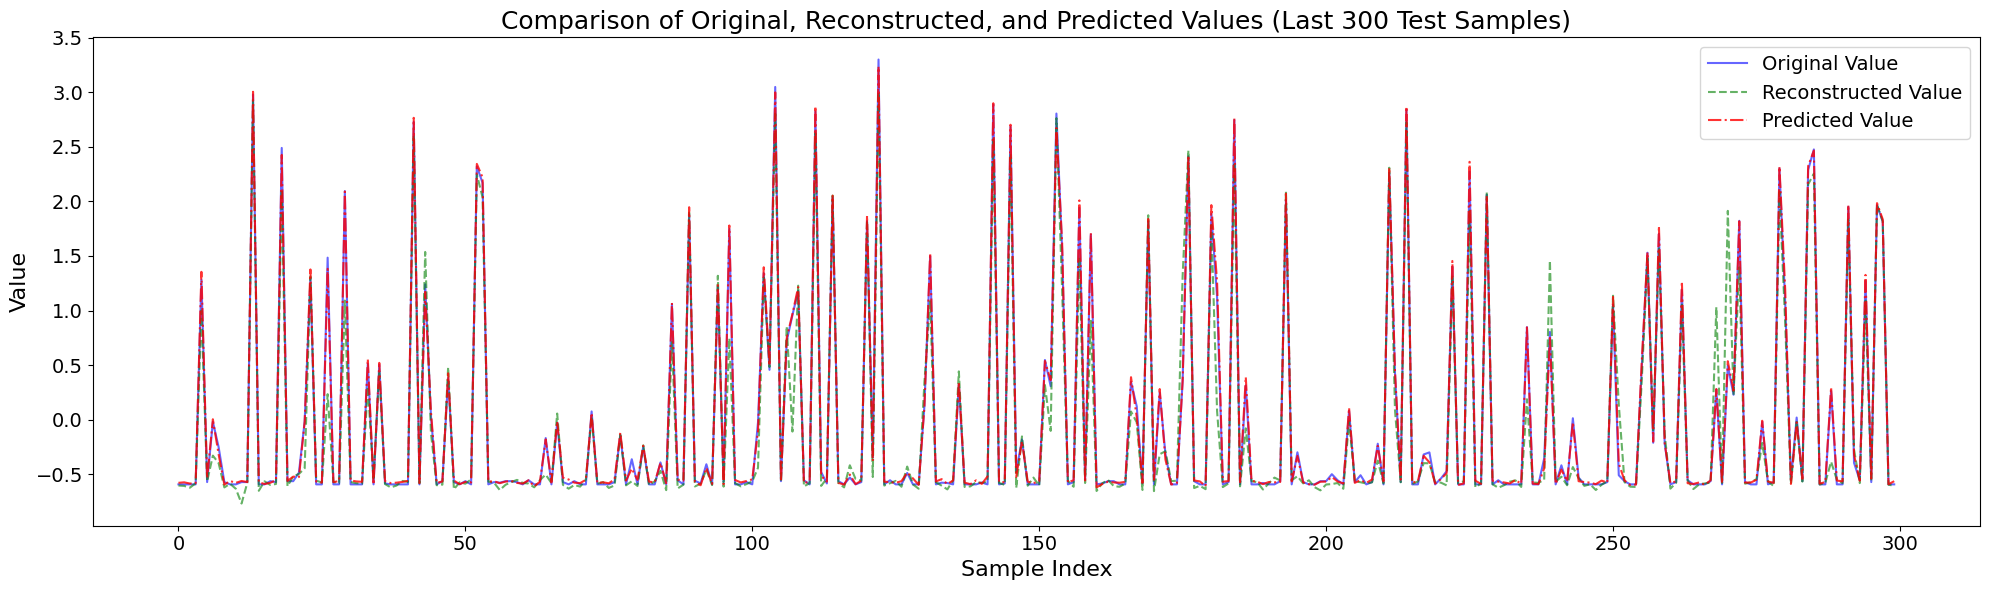

In [29]:
def plot_last_300_samples_and_save(original_data, reconstructed_data, prediction_data, sample_size=300, save_path=None):
    """
    Visualize and optionally save the original, reconstructed, and predicted values for the last N samples.

    Args:
    - original_data: 3D original data from the test set.
    - reconstructed_data: 3D reconstructed data from the autoencoder.
    - prediction_data: 2D predicted values from the prediction model (last step).
    - sample_size: Number of samples to visualize from the end of the test set.
    - save_path: File path to save the plot. If None, the plot is only displayed.
    """
    original_samples = original_data[-sample_size:]
    reconstructed_samples = reconstructed_data[-sample_size:]
    predicted_samples = prediction_data[-sample_size:]


    original_flat = original_samples.reshape(sample_size, -1)
    reconstructed_flat = reconstructed_samples.reshape(sample_size, -1)
    predicted_flat = predicted_samples


    time_axis = np.arange(sample_size)


    plt.figure(figsize=(20, 6))


    plt.plot(time_axis, original_flat[:, -1], label='Original Value', color='blue', alpha=0.6)


    plt.plot(time_axis, reconstructed_flat[:, -1], label='Reconstructed Value', color='green', linestyle='--', alpha=0.6)


    plt.plot(time_axis, predicted_flat[:, -1], label='Predicted Value', color='red', linestyle='-.', alpha=0.8)


    plt.title('Comparison of Original, Reconstructed, and Predicted Values (Last 300 Test Samples)', fontsize=18)
    plt.xlabel('Sample Index', fontsize=16)
    plt.ylabel('Value', fontsize=16)
    plt.legend(fontsize=14)


    plt.tick_params(axis='both', which='major', labelsize=14)

    # Save or display the plot
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved at: {save_path}")
    else:
        plt.show()

plot_last_300_samples_and_save(
    original_data=X_test,
    reconstructed_data=X_test_pred,
    prediction_data=X_test_forward_pred,
    sample_size=300,
    save_path='/content/last_300_samples_comparison.png'  # Specify your save path here
)

